In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing

import tensorflow as tf
import keras
from keras_hub.layers import SinePositionEncoding
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D, Input, BatchNormalization, LSTM, Attention, MultiHeadAttention
from tensorflow.keras.layers import Add, GlobalAveragePooling1D, MultiHeadAttention, Dropout, LayerNormalization, GlobalMaxPooling1D, Embedding
import keras
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score

from imblearn.over_sampling import SMOTE, RandomOverSampler

import os

import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.metrics")

In [4]:
!pip install git+https://github.com/johndpope/onnx-tensorflow

  Cloning https://github.com/johndpope/onnx-tensorflow to /tmp/pip-req-build-sjd8d6df
  Running command git clone --filter=blob:none --quiet https://github.com/johndpope/onnx-tensorflow /tmp/pip-req-build-sjd8d6df
  Resolved https://github.com/johndpope/onnx-tensorflow to commit 2bd7a4c83826be48ce68fb5c02f3a8c8600c4fb0
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 55.4 MB/s eta 0:00:00
  Created wheel for onnx-tf: filename=onnx_tf-1.10.0-py3-none-any.whl size=226734 sha256=e3b3fc6e9344b442317888aa5b5b75d27e22239946309c6160a2488d5f1f6891
  Stored in directory: /tmp/pip-ephem-wheel-cache-eu9utz21/wheels/df/a7/cc/9e1c7e1811e1b6774767e37290e3314d910e8baa2e8e5ae711
Successfully built onnx-tf
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR:

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Feed Forward

In [6]:
def build_feed_forward(num_classes):
    ff = Sequential()
    ff.add(Dense(units=256, activation='relu'))
    ff.add(Dense(units=256, activation='relu'))
    ff.add(Dense(num_classes, activation='softmax'))
    ff.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    return ff

# CNN

In [7]:
def build_basic_cnn(num_classes, seq_len):
    cnn = Sequential()
    cnn.add(Conv1D(filters=32,
            kernel_size=max(3, min(seq_len // 5, 50)),
            activation='relu',
            padding='same'))
    cnn.add(MaxPooling1D(pool_size=2))
    cnn.add(Conv1D(filters=32,
            kernel_size=max(3, min(seq_len // 10, 20)),
            activation='relu',
            padding='same'))
    cnn.add(MaxPooling1D(pool_size=2))
    cnn.add(Flatten())
    cnn.add(Dense(32, activation='relu'))
    cnn.add(Dropout(.25))
    cnn.add(Dense(num_classes, activation='softmax'))
    cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    return cnn

In [8]:
def build_cnn_with_attention_after(num_classes, seq_len):
    inputs = Input(shape=(seq_len, 1))

    x = Conv1D(filters=32,
            kernel_size=max(3, min(seq_len // 5, 50)),
            activation='relu',
            padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=32,
            kernel_size=max(3, min(seq_len // 10, 20)),
            activation='relu',
            padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    pos_encoding = SinePositionEncoding()(x)
    x = Add()([x, pos_encoding])

    attention_output = MultiHeadAttention(
        key_dim=32, num_heads=4, dropout=.25
    )(x, x, x)
    attention_output = Dropout(.25)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    x = Add()([x, attention_output])

    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(.25)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    cnn = Model(inputs=inputs, outputs=outputs)
    cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    return cnn

In [9]:
def build_cnn_with_attention_before(num_classes, seq_len):
    inputs = Input(shape=(seq_len, 1))
    pos_encoding = SinePositionEncoding()(inputs)
    x = Add()([inputs, pos_encoding])
    attention_output = MultiHeadAttention(
        key_dim=32, num_heads=4, dropout=.25
    )(x, x, x)

    attention_output = Dropout(.25)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    x = Add()([x, attention_output])

    x = Conv1D(filters=32,
            kernel_size=max(3, min(seq_len // 5, 50)),
            activation='relu',
            padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=32,
            kernel_size=max(3, min(seq_len // 10, 20)),
            activation='relu',
            padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(.25)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    cnn = Model(inputs=inputs, outputs=outputs)
    cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    return cnn


# LSTM

In [10]:
def build_basic_lstm(num_classes):
    lstm = Sequential()
    lstm.add(LSTM(units=32, return_sequences=True))
    lstm.add(LSTM(units=32, return_sequences=True))
    lstm.add(Flatten())
    lstm.add(Dense(units=32, activation='relu'))
    lstm.add(Dense(num_classes, activation='softmax'))
    lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    return lstm

In [11]:
def build_lstm_with_attention_after(num_classes, seq_len):
    inputs = Input(shape=(seq_len, 1))

    x = LSTM(units=32, return_sequences=True)(inputs)
    x = LSTM(units=32, return_sequences=True)(x)

    attention_output = MultiHeadAttention(
        key_dim=32, num_heads=4, dropout=.25
    )(x, x, x)
    attention_output = Dropout(.25)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    attention_output = Add()([x, attention_output])
    x = Flatten()(attention_output)
    x = Dense(32, activation='relu')(x)
    x = Dropout(.25)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    lstm = Model(inputs, outputs)
    lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    return lstm

In [12]:
def build_lstm_with_attention_before(num_classes, seq_len):
    inputs = Input(shape=(seq_len, 1))
    pos_encoding = SinePositionEncoding()(inputs)
    x = Add()([inputs, pos_encoding])
    attention_output = MultiHeadAttention(
        key_dim=32, num_heads=4, dropout=.25
    )(x, x, x)

    attention_output = Dropout(.25)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    x = Add()([x, attention_output])

    x = LSTM(units=32, return_sequences=True)(x)
    x = LSTM(units=32, return_sequences=True)(x)
    x = Flatten()(x)

    x = Dense(32, activation='relu')(x)
    x = Dropout(.25)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    lstm = Model(inputs, outputs)
    lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    return lstm

In [50]:
def train_model(model_name, dataset_name, X_train, y_train, X_test, y_test):
    seq_len = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    num_classes_test = len(np.unique(y_test))
    if num_classes != num_classes_test:
        print(dataset_name)
        print("Different number of classes!")
        return

    if model_name == "CNN":
        model = build_basic_cnn(num_classes, seq_len)
    elif model_name == "CNN Attention After":
        model = build_cnn_with_attention_after(num_classes, seq_len)
    elif model_name == "CNN Attention Before":
        model = build_cnn_with_attention_before(num_classes, seq_len)
    elif model_name == "LSTM":
        model = build_basic_lstm(num_classes)
    elif model_name == "LSTM Attention After":
        model = build_lstm_with_attention_after(num_classes, seq_len)
    elif model_name == "LSTM Attention Before":
        model = build_lstm_with_attention_before(num_classes, seq_len)

    model.fit(X_train, y_train, epochs=50, verbose=0)
    print(model.summary())
    return
    possible_labels = list(range(num_classes))
    y_train_pred_probs = model.predict(X_train)
    y_test_pred_probs = model.predict(X_test)

    y_train_pred = np.argmax(y_train_pred_probs, axis=1)
    y_test_pred = np.argmax(y_test_pred_probs, axis=1)

    train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred)
    test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)

    train_macro_f1 = f1_score(y_train, y_train_pred, average='macro', labels=possible_labels)
    test_macro_f1 = f1_score(y_test, y_test_pred, average='macro', labels=possible_labels)

    df = pd.read_excel('drive/MyDrive/ModelReportFinalPE.xlsx')
    df.loc[df["Name"] == dataset_name, f'{model_name} Train Accuracy'] = train_balanced_accuracy
    df.loc[df["Name"] == dataset_name, f'{model_name} Test Accuracy'] = test_balanced_accuracy
    df.loc[df["Name"] == dataset_name, f'{model_name} Train F1'] = train_macro_f1
    df.loc[df["Name"] == dataset_name, f'{model_name} Test F1'] = test_macro_f1
    df.to_excel('drive/MyDrive/ModelReportFinalPE.xlsx', index=False)

    print(f"Final train accuracy of {model_name} on dataset {dataset_name}: ", train_balanced_accuracy)
    print(f"Final test accuracy of {model_name} on dataset {dataset_name}: ", test_balanced_accuracy)

In [14]:
def preprocess(train, test):
    X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
    X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]

    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.transform(y_test)

    ros = RandomOverSampler()
    X_train, y_train = ros.fit_resample(X_train, y_train)

    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    if X_train.dtype == 'int64':
        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    return X_train, y_train, X_test, y_test

# Train Loop

In [15]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.gpu_device_name()


'/device:GPU:0'

In [ ]:
!nvidia-smi

In [54]:
id = 0
for dataset_name in os.listdir('drive/MyDrive/UCRArchive_2018/UCRArchive_2018'):
  if dataset_name == 'HouseTwenty': # used for test run to get param counts
    id = id + 1
    print("******* DATASET: ", dataset_name, "*******")
    dataset_path = os.path.join('drive/MyDrive/UCRArchive_2018/UCRArchive_2018', dataset_name)

    train_file = os.path.join(dataset_path, f"{dataset_name}_TRAIN.tsv")
    test_file = os.path.join(dataset_path, f"{dataset_name}_TEST.tsv")
    train = pd.read_csv(train_file, sep='\t', header=None)
    test = pd.read_csv(test_file, sep='\t', header=None)

    X_train, y_train, X_test, y_test = preprocess(train, test)

    train_model("CNN", dataset_name, X_train, y_train, X_test, y_test)
    train_model("CNN Attention After", dataset_name, X_train, y_train, X_test, y_test)
    train_model("CNN Attention Before", dataset_name, X_train, y_train, X_test, y_test)
    train_model("LSTM", dataset_name, X_train, y_train, X_test, y_test)
    train_model("LSTM Attention After", dataset_name, X_train, y_train, X_test, y_test)
    train_model("LSTM Attention Before", dataset_name, X_train, y_train, X_test, y_test)

    print(id/117)

******* DATASET:  HouseTwenty *******


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 2000, 32)       │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 1000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 1000, 32)       │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 500, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 16000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │       512,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,602,732 (6.11 MB)

 Trainable params: 534,242 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,068,490 (4.08 MB)

None


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_6 (Cast)       │ (None, 2000, 1)   │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 2000, 32)  │      1,632 │ cast_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 1000, 32)  │          0 │ conv1d_8[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 1000, 32)  │     20,512 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 500, 32)   │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sine_position_enco… │ (None, 500, 32)   │          0 │ max_pooling1d_9[… │
│ (SinePositionEncod… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 500, 32)   │          0 │ max_pooling1d_9[… │
│                     │                   │            │ sine_position_en… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 500, 32)   │     16,800 │ add_7[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_7[0][0],      │
│                     │                   │            │ add_7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 500, 32)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 500, 32)   │         64 │ dropout_15[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 500, 32)   │          0 │ add_7[0][0],      │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 16000)     │          0 │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 32)        │    512,032 │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 32)        │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 2)         │         66 │ dropout_16[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,653,324 (6.31 MB)

 Trainable params: 551,106 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,102,218 (4.20 MB)

None


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_7 (Cast)       │ (None, 2000, 1)   │          0 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_8 (Cast)       │ (None, 2000, 1)   │          0 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sine_position_enco… │ (None, 2000, 1)   │          0 │ cast_7[0][0]      │
│ (SinePositionEncod… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 2000, 1)   │          0 │ cast_8[0][0],     │
│                     │                   │            │ sine_position_en… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2000, 1)   │        897 │ add_9[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_9[0][0],      │
│                     │                   │            │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 2000, 1)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2000, 1)   │          2 │ dropout_18[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 2000, 1)   │          0 │ add_9[0][0],      │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 2000, 32)  │      1,632 │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 1000, 32)  │          0 │ conv1d_10[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 1000, 32)  │     20,512 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 500, 32)   │          0 │ conv1d_11[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 16000)     │          0 │ max_pooling1d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 32)        │    512,032 │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 32)        │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 2)         │         66 │ dropout_19[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,605,429 (6.12 MB)

 Trainable params: 535,141 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,070,288 (4.08 MB)

None


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 2000, 32)       │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 2000, 32)       │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 64000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │     2,048,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,182,316 (23.58 MB)

 Trainable params: 2,060,770 (7.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,121,546 (15.72 MB)

None


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_9 (Cast)       │ (None, 2000, 1)   │          0 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 2000, 32)  │      4,352 │ cast_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 2000, 32)  │      8,320 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2000, 32)  │     16,800 │ lstm_9[0][0],     │
│ (MultiHeadAttentio… │                   │            │ lstm_9[0][0],     │
│                     │                   │            │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 2000, 32)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2000, 32)  │         64 │ dropout_21[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 2000, 32)  │          0 │ lstm_9[0][0],     │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 64000)     │          0 │ add_11[0][0]      │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 32)        │  2,048,032 │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 32)        │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 2)         │         66 │ dropout_22[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,232,908 (23.78 MB)

 Trainable params: 2,077,634 (7.93 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,155,274 (15.85 MB)

None


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_10 (Cast)      │ (None, 2000, 1)   │          0 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_11 (Cast)      │ (None, 2000, 1)   │          0 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sine_position_enco… │ (None, 2000, 1)   │          0 │ cast_10[0][0]     │
│ (SinePositionEncod… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 2000, 1)   │          0 │ cast_11[0][0],    │
│                     │                   │            │ sine_position_en… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2000, 1)   │        897 │ add_12[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_12[0][0],     │
│                     │                   │            │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 2000, 1)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2000, 1)   │          2 │ dropout_24[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 2000, 1)   │          0 │ add_12[0][0],     │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 2000, 32)  │      4,352 │ add_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 2000, 32)  │      8,320 │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 64000)     │          0 │ lstm_11[0][0]     │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 32)        │  2,048,032 │ flatten_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 32)        │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 2)         │         66 │ dropout_25[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,185,013 (23.59 MB)

 Trainable params: 2,061,669 (7.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,123,344 (15.73 MB)

None
0.008547008547008548


# Results and Analysis

In [22]:
df = pd.read_excel('drive/MyDrive/ModelReportFinalPE.xlsx', sheet_name='Sheet1')

In [23]:
train_accuracy_cols = ['CNN Train Accuracy', 'CNN Attention Before Train Accuracy', 'CNN Attention After Train Accuracy', 'LSTM Train Accuracy', 'LSTM Attention Before Train Accuracy', 'LSTM Attention After Train Accuracy']
test_accuracy_cols = ['CNN Test Accuracy', 'CNN Attention Before Test Accuracy', 'CNN Attention After Test Accuracy', 'LSTM Test Accuracy', 'LSTM Attention Before Test Accuracy', 'LSTM Attention After Test Accuracy']
train_F1_cols = ['CNN Train F1', 'CNN Attention Before Train F1', 'CNN Attention After Train F1', 'LSTM Train F1', 'LSTM Attention Before Train F1', 'LSTM Attention After Train F1']
test_F1_cols = ['CNN Test F1', 'CNN Attention Before Test F1', 'CNN Attention After Test F1', 'LSTM Test F1', 'LSTM Attention Before Test F1', 'LSTM Attention After Test F1']

In [55]:
avg_test_scores = df[test_accuracy_cols].mean()
print("Avg Test Accuracy:")
print(avg_test_scores)
avg_f1_scores = df[test_F1_cols].mean()
print("Avg Test F1:")
print(avg_f1_scores)

Avg Test Accuracy:
CNN Test Accuracy                      0.673841
CNN Attention Before Test Accuracy     0.659126
CNN Attention After Test Accuracy      0.444038
LSTM Test Accuracy                     0.685411
LSTM Attention Before Test Accuracy    0.649694
LSTM Attention After Test Accuracy     0.673779
dtype: float64
Avg Test F1:
CNN Test F1                      0.645583
CNN Attention Before Test F1     0.630583
CNN Attention After Test F1      0.358270
LSTM Test F1                     0.665634
LSTM Attention Before Test F1    0.620429
LSTM Attention After Test F1     0.654561
dtype: float64


In [25]:
median_seq_len = df['Length'].median()
df_long_seq_len = df[df['Length'] >= median_seq_len]
df_short_seq_len = df[df['Length'] < median_seq_len]
short_seq_len_scores = df_long_seq_len[test_accuracy_cols].mean()
print("Avg Test Accuracy with longer seq lens:")
print(short_seq_len_scores)
long_seq_len_scores = df_short_seq_len[test_accuracy_cols].mean()
print("Avg Test Accuracy with shorter seq lens:")
print(long_seq_len_scores)

Avg Test Accuracy with longer seq lens:
CNN Test Accuracy                      0.633075
CNN Attention Before Test Accuracy     0.612495
CNN Attention After Test Accuracy      0.370968
LSTM Test Accuracy                     0.642775
LSTM Attention Before Test Accuracy    0.604629
LSTM Attention After Test Accuracy     0.629648
dtype: float64
Avg Test Accuracy with shorter seq lens:
CNN Test Accuracy                      0.716753
CNN Attention Before Test Accuracy     0.708212
CNN Attention After Test Accuracy      0.520954
LSTM Test Accuracy                     0.730290
LSTM Attention Before Test Accuracy    0.697130
LSTM Attention After Test Accuracy     0.720233
dtype: float64


In [26]:
median_train_len = df['Train '].median()
df_large_dataset = df[df['Train '] >= median_train_len]
df_small_dataset = df[df['Train '] < median_train_len]
larger_dataset_scores = df_large_dataset[test_accuracy_cols].mean()
print("Avg Test Accuracy with larger datasets:")
print(larger_dataset_scores)
smaller_dataset_scores = df_small_dataset[test_accuracy_cols].mean()
print("Avg Test Accuracy with smaller datasets:")
print(smaller_dataset_scores)

Avg Test Accuracy with larger datasets:
CNN Test Accuracy                      0.659336
CNN Attention Before Test Accuracy     0.620181
CNN Attention After Test Accuracy      0.354507
LSTM Test Accuracy                     0.640710
LSTM Attention Before Test Accuracy    0.612371
LSTM Attention After Test Accuracy     0.640200
dtype: float64
Avg Test Accuracy with smaller datasets:
CNN Test Accuracy                      0.688596
CNN Attention Before Test Accuracy     0.698743
CNN Attention After Test Accuracy      0.535113
LSTM Test Accuracy                     0.730882
LSTM Attention Before Test Accuracy    0.687660
LSTM Attention After Test Accuracy     0.707937
dtype: float64


In [27]:
median_num_classes = df['Class'].median()
df_more_classes = df[df['Class'] >= median_num_classes]
df_fewer_classes = df[df['Class'] < median_num_classes]
more_classes_scores = df_more_classes[test_accuracy_cols].mean()
print("Avg Test Accuracy with more classes:")
print(more_classes_scores)
fewer_classes_scores = df_fewer_classes[test_accuracy_cols].mean()
print("Avg Test Accuracy with fewer classes:")
print(fewer_classes_scores)

Avg Test Accuracy with more classes:
CNN Test Accuracy                      0.640301
CNN Attention Before Test Accuracy     0.617175
CNN Attention After Test Accuracy      0.352293
LSTM Test Accuracy                     0.633034
LSTM Attention Before Test Accuracy    0.608052
LSTM Attention After Test Accuracy     0.624326
dtype: float64
Avg Test Accuracy with fewer classes:
CNN Test Accuracy                      0.733734
CNN Attention Before Test Accuracy     0.734039
CNN Attention After Test Accuracy      0.607869
LSTM Test Accuracy                     0.778940
LSTM Attention Before Test Accuracy    0.724053
LSTM Attention After Test Accuracy     0.762089
dtype: float64


In [28]:
overfit_accuracy_cols = []
for train, test in zip(train_accuracy_cols, test_accuracy_cols):
  df[f'{train} Overfit'] = df[train] - df[test]
  overfit_accuracy_cols.append(f'{train} Overfit')
df.columns

Index(['ID', 'Type', 'Name', 'Train ', 'Test ', 'Class', 'Length',
       'CNN Train Accuracy', 'CNN Attention Before Train Accuracy',
       'CNN Attention After Train Accuracy', 'LSTM Train Accuracy',
       'LSTM Attention Before Train Accuracy',
       'LSTM Attention After Train Accuracy', 'CNN Test Accuracy',
       'CNN Attention Before Test Accuracy',
       'CNN Attention After Test Accuracy', 'LSTM Test Accuracy',
       'LSTM Attention Before Test Accuracy',
       'LSTM Attention After Test Accuracy', 'CNN Train F1',
       'CNN Attention Before Train F1', 'CNN Attention After Train F1',
       'LSTM Train F1', 'LSTM Attention Before Train F1',
       'LSTM Attention After Train F1', 'CNN Test F1',
       'CNN Attention Before Test F1', 'CNN Attention After Test F1',
       'LSTM Test F1', 'LSTM Attention Before Test F1',
       'LSTM Attention After Test F1', 'CNN Train Accuracy Overfit',
       'CNN Attention Before Train Accuracy Overfit',
       'CNN Attention After Tra

In [29]:
scores = df[overfit_accuracy_cols].mean()
print("Avg Accuracy Difference b/w train and test (Overfitting):")
print(scores)

Avg Accuracy Difference b/w train and test (Overfitting):
CNN Train Accuracy Overfit                      0.190372
CNN Attention Before Train Accuracy Overfit     0.186087
CNN Attention After Train Accuracy Overfit      0.038391
LSTM Train Accuracy Overfit                     0.199031
LSTM Attention Before Train Accuracy Overfit    0.171245
LSTM Attention After Train Accuracy Overfit     0.184603
dtype: float64


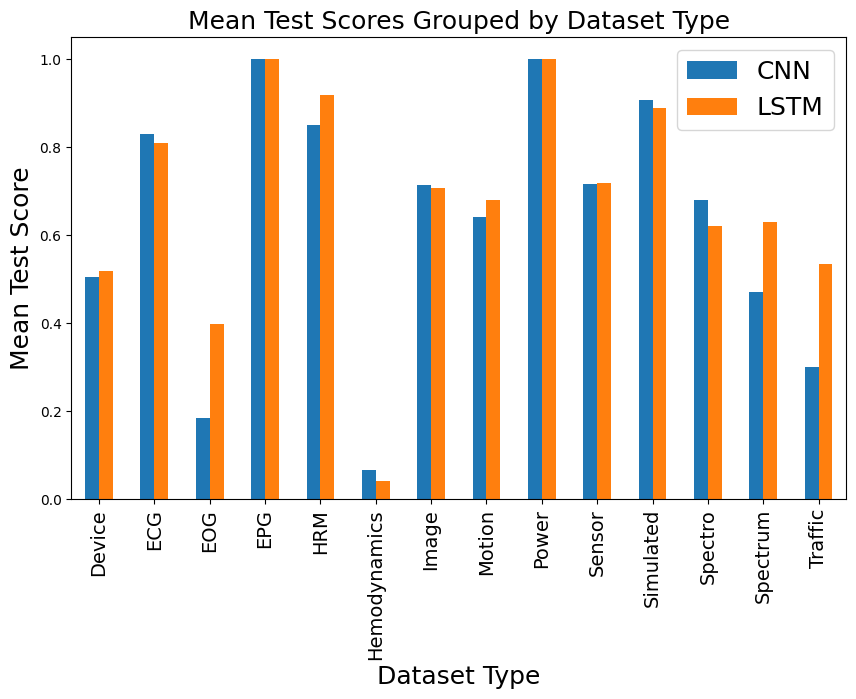

In [30]:
mean_test_scores = df.groupby('Type')[['CNN Test Accuracy', 'LSTM Test Accuracy']].mean()

mean_test_scores.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Test Scores Grouped by Dataset Type', fontsize=18)
plt.xlabel('Dataset Type', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('Mean Test Score', fontsize=18)
plt.legend(['CNN', 'LSTM'], fontsize=18, title_fontsize=18)
plt.show()


In [31]:
mean_test_scores

,CNN Test Accuracy,LSTM Test Accuracy
Type,,
Device,0.505737,0.518707
ECG,0.828914,0.809924
EOG,0.185115,0.397939
EPG,1.000000,1.000000
HRM,0.849586,0.917311
Hemodynamics,0.065705,0.041667
Image,0.713211,0.706266
Motion,0.641645,0.679171
Power,1.000000,1.000000


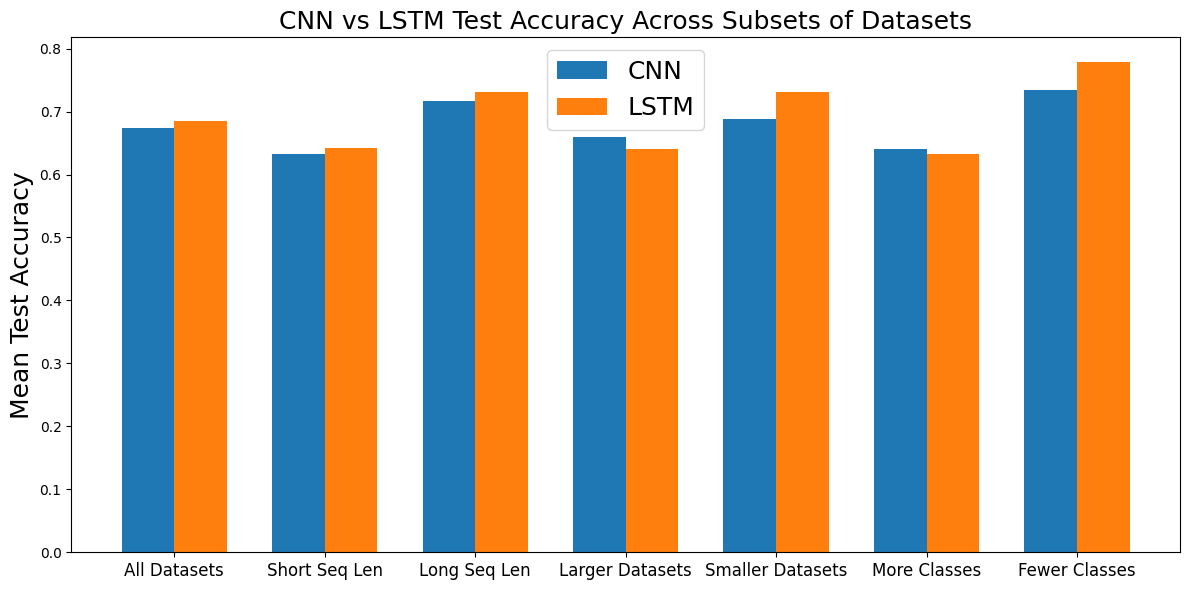

In [73]:
series = {
    'All Datasets': avg_test_scores,
    'Short Seq Len': short_seq_len_scores,
    'Long Seq Len': long_seq_len_scores,
    'Larger Datasets': larger_dataset_scores,
    'Smaller Datasets': smaller_dataset_scores,
    'More Classes': more_classes_scores,
    'Fewer Classes': fewer_classes_scores,
}

x_labels = list(series.keys())
x = np.arange(len(x_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
cnn_scores = [series['CNN Test Accuracy'] for series in series.values()]
lstm_scores = [series['LSTM Test Accuracy'] for series in series.values()]

rects1 = ax.bar(x - width/2, cnn_scores, width, label='CNN')
rects2 = ax.bar(x + width/2, lstm_scores, width, label='LSTM')

ax.set_ylabel('Mean Test Accuracy', fontsize=18)
ax.set_title('CNN vs LSTM Test Accuracy Across Subsets of Datasets', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, fontsize=12)
ax.legend(fontsize=18)

fig.tight_layout()
plt.show()


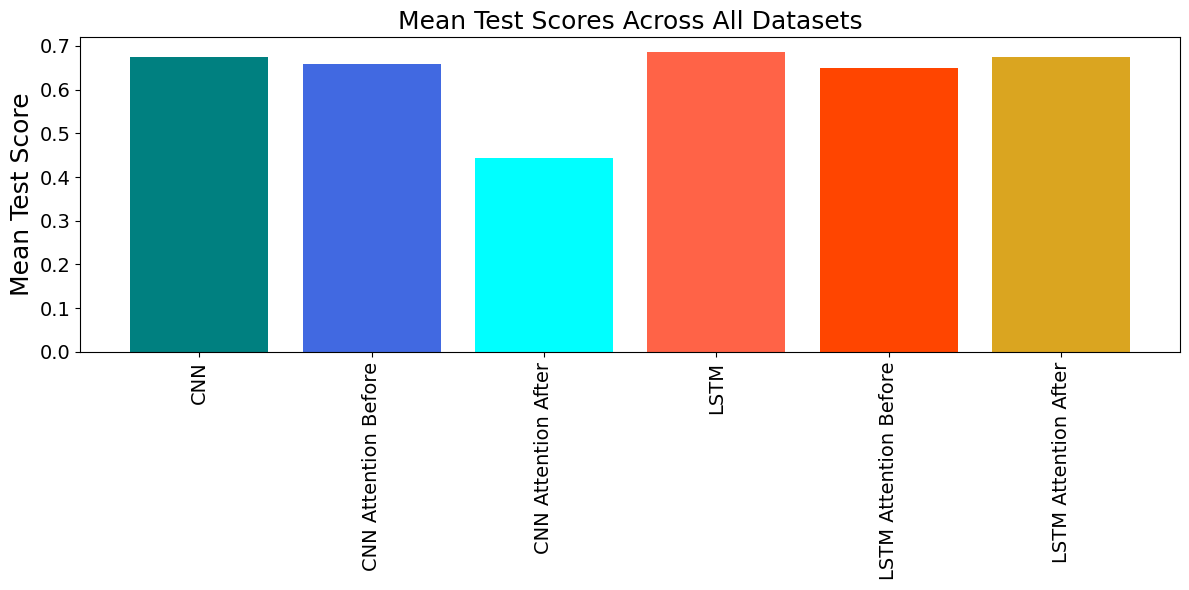

In [49]:
labels = ['CNN', 'CNN Attention Before', 'CNN Attention After', 'LSTM', 'LSTM Attention Before', 'LSTM Attention After']
colors = ["teal", "royalblue", "cyan", "tomato", "orangered", "goldenrod"]

plt.figure(figsize=(12, 6))
plt.bar(labels, avg_test_scores, color=colors)
plt.ylabel("Mean Test Score", fontsize=18)
plt.title("Mean Test Scores Across All Datasets", fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()